<h3>Practica 1:Sensado y análisis de audio</h3>
<b>Diana Jaramillo</b>


In [ ]:
# system libraries
import os
import sys

# data 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# audio
import IPython.display as ipd
from IPython.display import Audio, display, Markdown
import librosa
import librosa.display

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
AuduiDir='E:\Cicese\Sensores\P1\\'

Extraccion de las actividades y de las direcciones de los archivos, asi como la separacion de los archivos para pruebas en otro dataframe

In [132]:
dirlist=os.listdir(AuduiDir)
activity=[]
path=[]
print(dirlist)
for folder in dirlist:
        if not folder.startswith('Test'):
            fname = os.listdir(AuduiDir + '/' + folder)
            for f in fname:
                part = f.split('_')[1].split('_')
                activity.append(part[0])
                path.append(AuduiDir + '/' + folder + '/' + f)
TestData=pd.DataFrame(columns=['Activity','Path'])
for i in dirlist:
    if i==dirlist[-2]:
        fname = os.listdir(AuduiDir + '/' + i)
        for f in fname:
            part = f.split('_')[1].split('_')
            TestData.loc[len(TestData)] = [part[0], AuduiDir + '/' + i + '/' + f]
Dataset=pd.DataFrame(columns=['Activity','Path'])
for i in range(len(activity)):
    Dataset.loc[len(Dataset)] = [activity[i], path[i]]
Dataset['Activity']=Dataset['Activity'].str.upper()
#Estandarizacion de los datos
Dataset['Activity']=Dataset['Activity'].str.replace('NULO','NULA')
TestData['Activity']=TestData['Activity'].str.upper()
print('--------Data set-------------')
print(Dataset['Activity'].value_counts())
print('--------Test data-------------')
print(TestData['Activity'].value_counts())

['Diana Itzel', 'Diana Jaramillo', 'Edgar Nava', 'Eric R', 'Ian Svén', 'Javier R', 'José Juárez', 'Mariel Lopez', 'Norman O', 'Test Joan Raygoza', 'Zarif León']
--------Data set-------------
Activity
BANO       30
COCINA     30
NULA       30
OFICINA    30
PASOS      30
SALA       30
Name: count, dtype: int64
--------Test data-------------
Activity
BANO       3
COCINA     3
NULA       3
OFICINA    3
PASOS      3
SALA       3
Name: count, dtype: int64


Cargar los datos del audio y su sampling rate

In [52]:
filedata=[]
samplingrate=[]
for i in Dataset['Path']:
    d,sr=librosa.load(i)
    filedata.append(d)
    samplingrate.append(sr)
Dataset['File Data']=filedata
Dataset['Samplig Rate']=samplingrate


Calcular el RMS y ver el promedio que tienen por actividad para tener una idea de como se encuentran lso archivos relativamente sin procesar, asi como aplicar funciones de normalizacion de volumen y reduccion de sonido de fondo.

RMS promedio general: 0.01813898


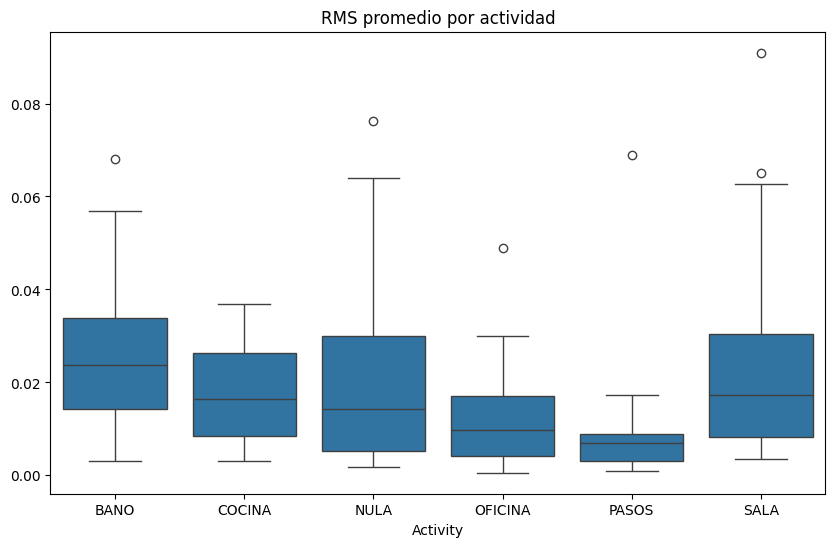

In [94]:
average_rms=[]
for i in Dataset['File Data']:
    rms=librosa.feature.rms(y=i)
    average_rms.append(np.mean(rms))
plt.figure(figsize=(10,6))
sns.boxplot(x=Dataset['Activity'],y=average_rms)
plt.title('RMS promedio por actividad')
print('RMS promedio general:',np.mean(average_rms))

normalized_audios=[]
for i in Dataset['File Data']:
    normalized_audios.append(librosa.util.normalize(i))

Dataset['Normalized Audio']=normalized_audios

noise_reduced_audios=[]
for i in Dataset['Normalized Audio']:
    reduced_noise=librosa.effects.preemphasis(i)
    noise_reduced_audios.append(reduced_noise)
Dataset['Noise Reduced Audio']=noise_reduced_audios





Muestras de como quedo un audio despues de cada proceso

In [98]:
ipd.display(Audio(data=Dataset['File Data'][0], rate=Dataset['Samplig Rate'][0]))

In [97]:
ipd.display(Audio(data=Dataset['Normalized Audio'][0], rate=Dataset['Samplig Rate'][0]))

In [88]:
ipd.display(Audio(data=Dataset['Noise Reduced Audio'][0], rate=Dataset['Samplig Rate'][0]))

Espectograma promedio de todo el dataset de los audios en sus distintas etapas de procesamiento

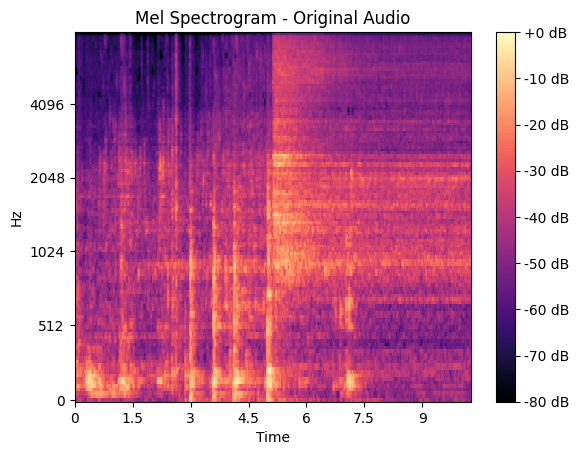

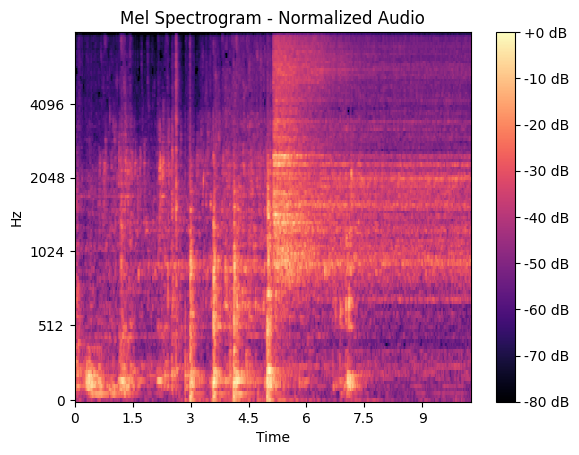

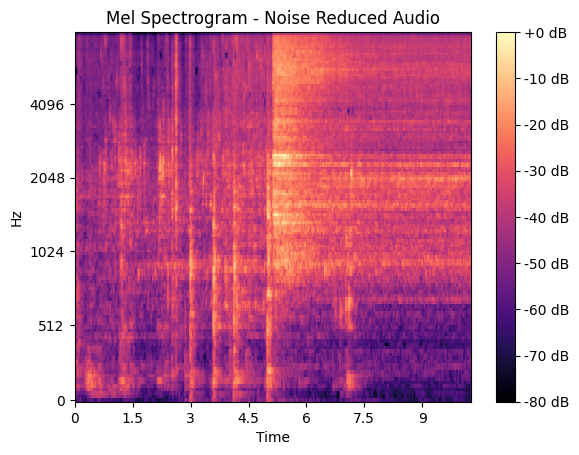

In [100]:
#mel spectrogram
original_spectrograms=librosa.feature.melspectrogram(y=Dataset['File Data'][0], sr=Dataset['Samplig Rate'][0])
librosa.display.specshow(librosa.power_to_db(original_spectrograms, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.figure(1)
plt.title('Mel Spectrogram - Original Audio')
plt.colorbar(format='%+2.0f dB')
plt.show()
plt.figure(2)
normalized_spactograms=librosa.feature.melspectrogram(y=Dataset['Normalized Audio'][0], sr=Dataset['Samplig Rate'][0])
librosa.display.specshow(librosa.power_to_db(normalized_spactograms, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Normalized Audio')
plt.colorbar(format='%+2.0f dB')
plt.show()
plt.figure(3)
noise_spectograms=librosa.feature.melspectrogram(y=Dataset['Noise Reduced Audio'][0], sr=Dataset['Samplig Rate'][0])
librosa.display.specshow(librosa.power_to_db(noise_spectograms, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram - Noise Reduced Audio')
plt.colorbar(format='%+2.0f dB')
plt.show()

Obtencion de las caracteristicas usando MFCC, RMS y ZCR

In [116]:
audiodescriptors=pd.DataFrame(columns=['Activity','MFCC (13 coeficientes)','RMS','Zero Crossing Rate'])
for i in range(len(Dataset)):
    mfcc=librosa.feature.mfcc(y=Dataset['Noise Reduced Audio'][i], sr=Dataset['Samplig Rate'][i], n_mfcc=13).transpose()
    rms=librosa.feature.rms(y=Dataset['Noise Reduced Audio'][i])
    zcr=librosa.feature.zero_crossing_rate(y=Dataset['Noise Reduced Audio'][i])
    audiodescriptors.loc[len(audiodescriptors)] = [Dataset['Activity'][i],mfcc,rms,zcr]    

Aplicar lo  mismo para los datos que se separaron de test para poder realizar la pradiccion con estos datos

In [127]:
tdata=[]
tsr=[]
for i in TestData['Path']:
    d,sr=librosa.load(i)
    tdata.append(d)
    tsr.append(sr)
TestData['File Data']=tdata
TestData['Samplig Rate']=tsr
test_audiodescriptors=pd.DataFrame(columns=['Activity','MFCC (13 coeficientes)','RMS','Zero Crossing Rate'])
for i in range(len(TestData)):
    mfcc=librosa.feature.mfcc(y=TestData['File Data'][i], sr=TestData['Samplig Rate'][i], n_mfcc=13).transpose()
    rms=librosa.feature.rms(y=TestData['File Data'][i])
    zcr=librosa.feature.zero_crossing_rate(y=TestData['File Data'][i])
    test_audiodescriptors.loc[len(test_audiodescriptors)] = [TestData['Activity'][i],mfcc,rms,zcr]


Modelo de random forest y separacion de datos en train y test internos

Cada modelo incluye su matriz de confusion y el F1 score

Classification Report:
               precision    recall  f1-score   support

        BANO       0.00      0.00      0.00         3
      COCINA       0.33      0.67      0.44         3
        NULA       1.00      0.33      0.50         3
     OFICINA       0.75      1.00      0.86         3
       PASOS       0.00      0.00      0.00         3
        SALA       1.00      1.00      1.00         3

    accuracy                           0.50        18
   macro avg       0.51      0.50      0.47        18
weighted avg       0.51      0.50      0.47        18

F1 Score: 0.466931216931217


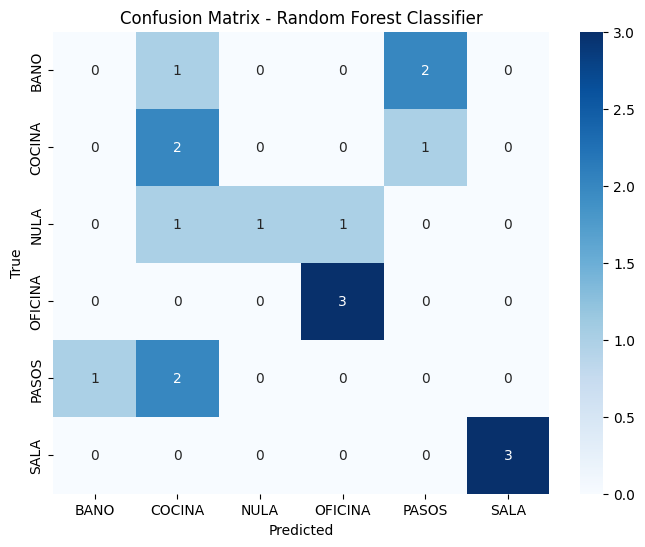

In [134]:
label_encoder=LabelEncoder()
categories=label_encoder.fit_transform(audiodescriptors['Activity'])
features=pd.DataFrame(columns=[f'MFCC_{i+1}' for i in range(13)]+['RMS','ZCR'])
for i in range(len(audiodescriptors)):
    mfcc_mean=np.mean(audiodescriptors['MFCC (13 coeficientes)'][i], axis=0)
    rms_mean=np.mean(audiodescriptors['RMS'][i])
    zcr_mean=np.mean(audiodescriptors['Zero Crossing Rate'][i])
    feature_vector=np.hstack((mfcc_mean, rms_mean, zcr_mean))
    features.loc[i]=feature_vector
X_train, X_test, y_train, y_test = train_test_split(features, categories, test_size=0.1, random_state=42, stratify=categories)
randforest=RandomForestClassifier(n_estimators=100, random_state=42)
randforest.fit(X_train, y_train)
y_pred=randforest.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))
conf_matrix=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()




Usando un SVC

Classification Report SVC:
               precision    recall  f1-score   support

        BANO       0.50      0.33      0.40         3
      COCINA       0.40      0.67      0.50         3
        NULA       0.20      0.33      0.25         3
     OFICINA       1.00      0.33      0.50         3
       PASOS       0.00      0.00      0.00         3
        SALA       0.50      0.67      0.57         3

    accuracy                           0.39        18
   macro avg       0.43      0.39      0.37        18
weighted avg       0.43      0.39      0.37        18

F1 Score SVC: 0.37023809523809526


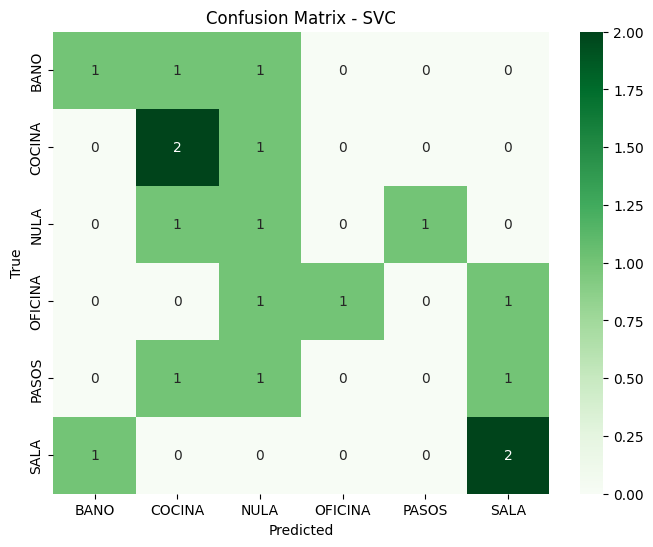

In [135]:
SVC_model=SVC(kernel='linear', C=1, random_state=42)
SVC_model.fit(X_train, y_train)
y_pred_svc=SVC_model.predict(X_test)
print('Classification Report SVC:\n', classification_report(y_test, y_pred_svc, target_names=label_encoder.classes_))
print('F1 Score SVC:', f1_score(y_test, y_pred_svc, average='weighted'))
conf_matrix_svc=confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.title('Confusion Matrix - SVC')
plt.show()

Modelo usando KNN

Classification Report KNN:
               precision    recall  f1-score   support

        BANO       0.00      0.00      0.00         3
      COCINA       0.20      0.33      0.25         3
        NULA       0.00      0.00      0.00         3
     OFICINA       0.33      0.33      0.33         3
       PASOS       0.00      0.00      0.00         3
        SALA       0.33      0.33      0.33         3

    accuracy                           0.17        18
   macro avg       0.14      0.17      0.15        18
weighted avg       0.14      0.17      0.15        18

F1 Score KNN: 0.1527777777777778


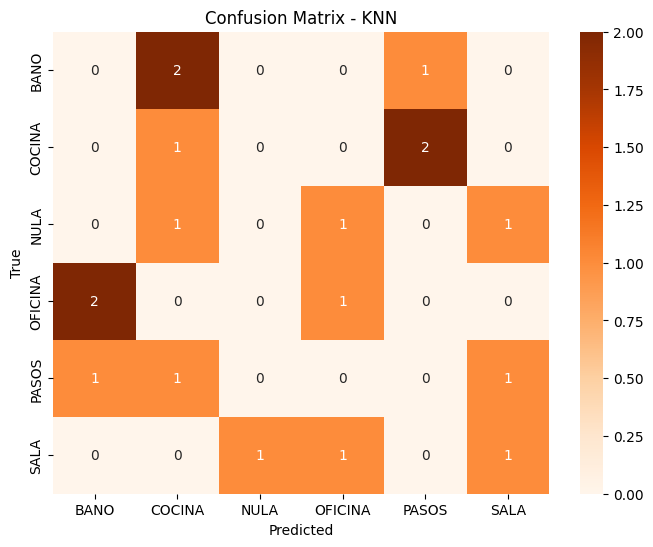

In [136]:
knn_model=KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn=knn_model.predict(X_test)
print('Classification Report KNN:\n', classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))
print('F1 Score KNN:', f1_score(y_test, y_pred_knn, average='weighted'))
conf_matrix_knn=confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - KNN')
plt.show()

Preparacion de los datos de test para poder usarlos y predecir usando los modelos

Primera prueba de modelo usando random forest

Test Data Classification Report:
               precision    recall  f1-score   support

        BANO       0.00      0.00      0.00         3
      COCINA       0.00      0.00      0.00         3
        NULA       0.14      0.67      0.24         3
     OFICINA       0.00      0.00      0.00         3
       PASOS       0.00      0.00      0.00         3
        SALA       0.00      0.00      0.00         3

    accuracy                           0.11        18
   macro avg       0.02      0.11      0.04        18
weighted avg       0.02      0.11      0.04        18

F1 Score Test Data: 0.0392156862745098


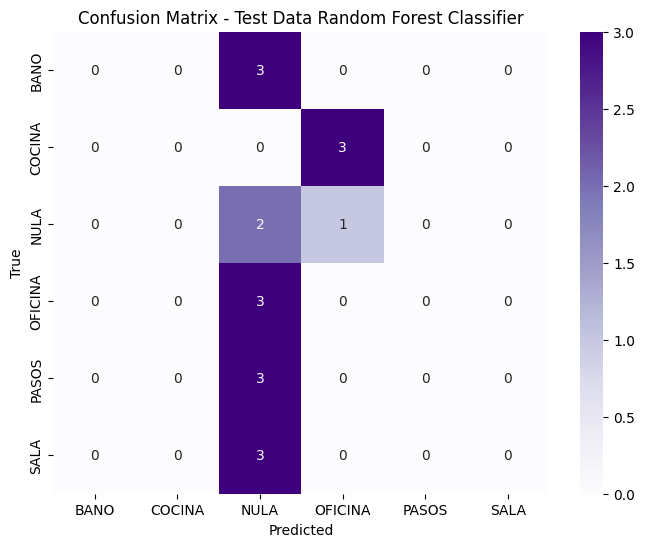

In [128]:
testlabels=label_encoder.transform(test_audiodescriptors['Activity'])
testfeatures=pd.DataFrame(columns=[f'MFCC_{i+1}' for i in range(13)]+['RMS','ZCR'])
for i in range(len(test_audiodescriptors)):
    mfcc_mean=np.mean(test_audiodescriptors['MFCC (13 coeficientes)'][i], axis=0)
    rms_mean=np.mean(test_audiodescriptors['RMS'][i])
    zcr_mean=np.mean(test_audiodescriptors['Zero Crossing Rate'][i])
    feature_vector=np.hstack((mfcc_mean, rms_mean, zcr_mean))
    testfeatures.loc[i]=feature_vector
y_test_pred=randforest.predict(testfeatures)
print('Test Data Classification Report:\n', classification_report(testlabels, y_test_pred, target_names=label_encoder.classes_))
print('F1 Score Test Data:', f1_score(testlabels, y_test_pred, average='weighted'))
conf_matrix_test=confusion_matrix(testlabels, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Purples', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Data Random Forest Classifier')
plt.show()

Prueba de modelo SVC con datos de test

Test Data SVC Classification Report:
               precision    recall  f1-score   support

        BANO       0.00      0.00      0.00         3
      COCINA       0.00      0.00      0.00         3
        NULA       0.33      0.67      0.44         3
     OFICINA       0.11      0.33      0.17         3
       PASOS       0.33      0.33      0.33         3
        SALA       0.00      0.00      0.00         3

    accuracy                           0.22        18
   macro avg       0.13      0.22      0.16        18
weighted avg       0.13      0.22      0.16        18

F1 Score Test Data SVC: 0.15740740740740738


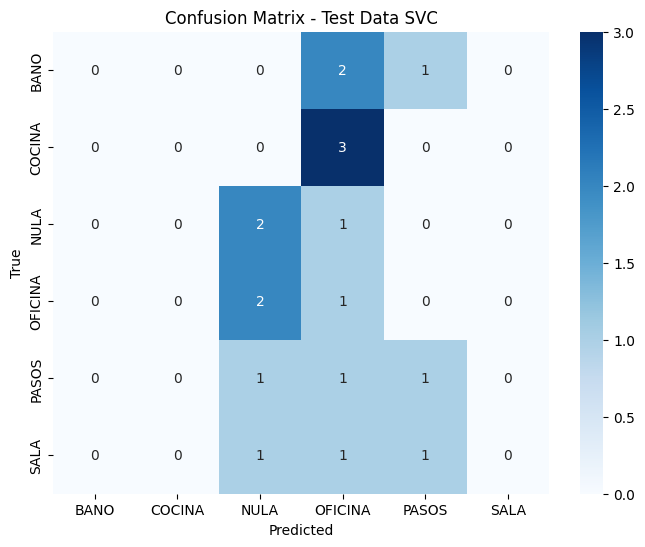

In [129]:
y_test_pred_svc=SVC_model.predict(testfeatures)
print('Test Data SVC Classification Report:\n', classification_report(testlabels, y_test_pred_svc, target_names=label_encoder.classes_))
print('F1 Score Test Data SVC:', f1_score(testlabels, y_test_pred_svc, average='weighted'))
conf_matrix_test_svc=confusion_matrix(testlabels, y_test_pred_svc)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test_svc, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Data SVC')
plt.show()


Prueba de modelo KNN con datos de test

Test Data KNN Classification Report:
               precision    recall  f1-score   support

        BANO       0.00      0.00      0.00         3
      COCINA       0.00      0.00      0.00         3
        NULA       0.14      0.67      0.24         3
     OFICINA       0.00      0.00      0.00         3
       PASOS       0.00      0.00      0.00         3
        SALA       0.00      0.00      0.00         3

    accuracy                           0.11        18
   macro avg       0.02      0.11      0.04        18
weighted avg       0.02      0.11      0.04        18

F1 Score Test Data KNN: 0.0392156862745098


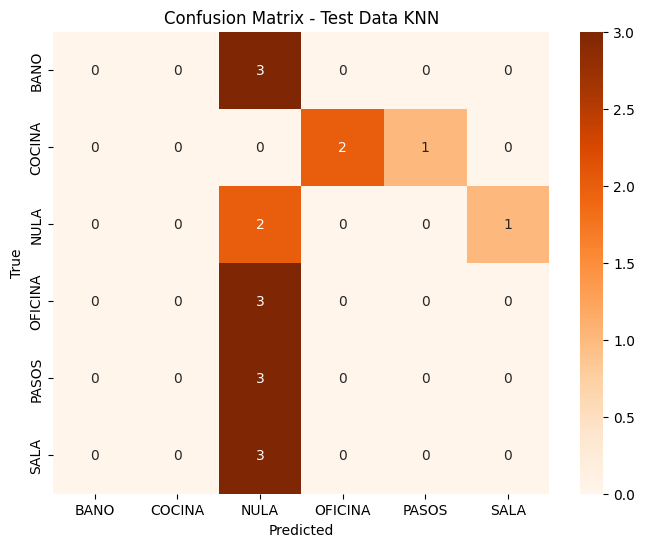

In [130]:
y_test_pred_knn=knn_model.predict(testfeatures)
print('Test Data KNN Classification Report:\n', classification_report(testlabels, y_test_pred_knn, target_names=label_encoder.classes_))
print('F1 Score Test Data KNN:', f1_score(testlabels, y_test_pred_knn, average='weighted'))
conf_matrix_test_knn=confusion_matrix(testlabels, y_test_pred_knn)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test_knn, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Data KNN')
plt.show()